In [2]:

import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from Configs.configs import IMG_SHAPE,CLASSES
from omegaconf import OmegaConf
import CV_algs 

In [3]:
conf = OmegaConf.load('config.yaml')


In [4]:
def reduce_classification(line_class):
    # procedure for classification problem reduction
    # you can add whatever you want
    # There is the simlest case of 4 classes (0 - Empty, 1 - Roadbed, 2 - Solid, 3 - Dash)
    if line_class == CLASSES.EMPY:
        return 0
    if line_class == CLASSES.SOLID:
        return 2
    if line_class == CLASSES.SOLID_SOLID:
        return 2
    if line_class == CLASSES.SOLID_DASH:
        return 2
    if line_class == CLASSES.DASH_SOLID:
        return 2
    if line_class == CLASSES.DASH:
        return 3
    return None

In [5]:
# Getting paths from config file
destination_rgb = conf.source_rgb
destination_mask = conf.source_mask
destination_to_save = conf.destination_to_save

# in Out dir creating the folders (rgb,mask,result,line_info)
# There is will be warning if dir exists, but it's ok
destination_to_save_rgb = os.path.join(destination_to_save,"rgb")
try: 
    os.mkdir(destination_to_save_rgb) 
except OSError as error: 
    print(error)
destination_to_save_mask = os.path.join(destination_to_save,"mask")
try: 
    os.mkdir(destination_to_save_mask) 
except OSError as error: 
    print(error)
destination_to_save_result = os.path.join(destination_to_save,"result")
try: 
    os.mkdir(destination_to_save_result) 
except OSError as error: 
    print(error)
destination_to_save_info = os.path.join(destination_to_save,"line_info")
try: 
    os.mkdir(destination_to_save_info) 
except OSError as error: 
    print(error)


[WinError 183] Невозможно создать файл, так как он уже существует: 'TESTS/test2\\rgb'
[WinError 183] Невозможно создать файл, так как он уже существует: 'TESTS/test2\\mask'
[WinError 183] Невозможно создать файл, так как он уже существует: 'TESTS/test2\\result'
[WinError 183] Невозможно создать файл, так как он уже существует: 'TESTS/test2\\line_info'


In [6]:
# some parameters from config
destination_SIZE = conf.target_size # is size of final images and masks
exceptions = conf.exceptions # these names will be omitted for processing

#used parameters
list_dir = os.listdir(destination_rgb)
Y_SHAPE,X_SHAPE = IMG_SHAPE

#name of final images
name_counter = 0


for i in list_dir:
    #avoid black list
    if i in exceptions:
        continue
    #img_name without extension
    img_num = os.path.splitext(i)[0]
    print(img_num)
    
    #take the rgb
    img_real = cv2.imread(os.path.join(destination_rgb,f"{img_num}.png"))
    img_real =cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB)
    img_real = cv2.resize(img_real,(X_SHAPE,Y_SHAPE),interpolation=cv2.INTER_CUBIC)
    #take the mask
    mask = cv2.imread(os.path.join(destination_mask,f"{img_num}.png"))
    mask = cv2.resize(mask,(X_SHAPE,Y_SHAPE),interpolation=cv2.INTER_CUBIC)
    #bird view
    warped, (M,Minv) = CV_algs.preprocess_image(mask,visualise=False)
    #thresholding
    binary_mark =  (np.sum(warped,axis=2) == 441).astype("uint8")
    kernel = np.ones((2, 2), 'uint8')
    binary_mark = cv2.dilate(binary_mark, kernel, iterations=1)
    binary_roadbed = (np.sum(warped,axis=2) == 320).astype("uint8")
    binary_roadbed = np.logical_or(binary_mark,binary_roadbed).astype("uint8")
    kernel = np.ones((10, 10), 'uint8')
    binary_roadbed = cv2.dilate(binary_roadbed, kernel, iterations=1)    
    binary_roadbed = CV_algs.smalldeleteArreas(binary_roadbed,diagnostics= False)
    
    #start line search and classification  (uncomment visualisation part if needed)
    #simple_test_output = CV_algs.simple_test(binary_mark, binary_roadbed,visualisation=True,diagnostics=True)
    simple_test_output = CV_algs.simple_test(binary_mark, binary_roadbed)
    #get out
    success_mark, poly_param, (lc,rc) = simple_test_output[0]
    success_roadbed,roadbed_fit = simple_test_output[1]
    img_poly,out = simple_test_output[2]
    #init final img
    result = img_real
    
    #creating zero final mask 
    Mat = np.zeros(destination_SIZE)
    # line index counter
    counter = 1
    # init empty line_info 
    lanes_class_information = ""
    # fill the lanes_class_information-line_info Mat-mask and result with road_bed
    if success_roadbed:
        result = CV_algs.draw(img_real, warped, Minv, roadbed_fit,lineColor=(255,0,0))
        
        Mat = CV_algs.addLine(Mat,IMG_SHAPE,Minv,roadbed_fit[0],counter)
        lanes_class_information += f"{1} "
        counter +=1
        Mat = CV_algs.addLine(Mat,IMG_SHAPE,Minv,roadbed_fit[1],counter)
        lanes_class_information += f"{1} "
        counter +=1
        
    # fill the lanes_class_information-line_info Mat-mask and result with road_marks
    if success_mark:
        result2 = CV_algs.draw(img_real, warped, Minv, poly_param, color =(220,0,110),lineColor=(0,0,0))
        result = cv2.addWeighted(result, 0.5, result2, 0.5, 0)
        result = cv2.putText(result, str(lc), (10,100), cv2.FONT_HERSHEY_PLAIN, 2, (0,255,0),thickness = 2)
        result = cv2.putText(result, str(rc), (IMG_SHAPE[1] - 300,100), cv2.FONT_HERSHEY_PLAIN, 2, (0,255,0),thickness = 2)
            
        Mat = CV_algs.addLine(Mat,IMG_SHAPE,Minv,poly_param[0],counter)
        lanes_class_information += f"{reduce_classification(lc)} " 
        counter +=1
        Mat = CV_algs.addLine(Mat,IMG_SHAPE,Minv,poly_param[1],counter)
        lanes_class_information += f"{reduce_classification(rc)} "
        counter +=1
        if reduce_classification(lc)>3 | reduce_classification(rc)>3:
            raise Exception("your classification order is broken")
    #fill line_info up to 6 zero lines
    while counter <= 6:
        lanes_class_information += f"{0} "
        counter +=1
    #put text on result img
    result = cv2.putText(result, f"frame:{i}", (10,50), cv2.FONT_HERSHEY_PLAIN, 2, (0,255,0),thickness = 2)
    
    #img_for_save =cv2.hconcat([img_real,mask,result])
    img_for_save = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    # for training we save results if mark is ok. It works better for training
    if success_mark:
        cv2.imwrite(os.path.join(destination_to_save_rgb,f"{name_counter}".zfill(5)+".png"),cv2.resize(img_real,(destination_SIZE[1],destination_SIZE[0])))
        cv2.imwrite(os.path.join(destination_to_save_mask,f"{name_counter}".zfill(5) + ".png"),Mat)
        cv2.imwrite(os.path.join(destination_to_save_result,f"{name_counter}".zfill(5) + ".png"),img_for_save)
        f = open(os.path.join(destination_to_save_info,f"{name_counter}".zfill(5) + ".txt"), "w")
        f.write(lanes_class_information)
        f.close()
        name_counter +=1
        
        
    #plt.imshow(Mat)
    #plt.show()
    #plt.imshow(result)
    #plt.show()

0
1
2
3
4
5
6


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

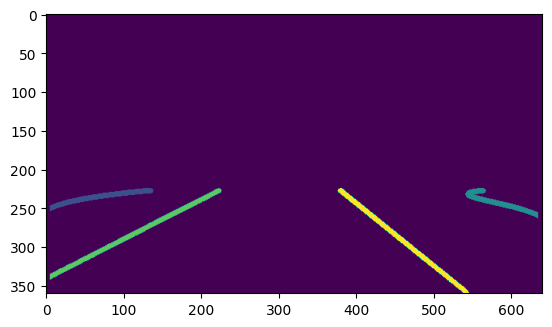

In [11]:
plt.imshow(Mat)

In [6]:
import csv
import pandas as pd
rgb_paths = []
mask_paths = []
lane_infos = []
list_dir = os.listdir(destination_to_save_mask)
for name in list_dir:
    i = os.path.splitext(name)[0]
    rgb_paths.append(f"rgb/{i}.png")
    mask_paths.append(f"mask/{i}.png")
    
    with open(os.path.join(destination_to_save_info,f"{i}.txt"),"r") as f:
        line = f.readline()
        lane_infos.append(line[:-1])
cv_name = os.path.join(destination_to_save,"DataSet.csv")
pd.DataFrame({"path_to_input":rgb_paths, "path_to_mask" : mask_paths, "lane_classes": lane_infos}).to_csv(cv_name,index=False)